# Präsenzversuch zum Laval-Rotor

Name: Zidane Bürmann
Datum: 01.02.2024
Gruppe: 37

## Forschungsfrage

Wie können Eigenfrequenzen am Beispiel der Prüfstände ermittelt und dargestellt werden?

## Erster Versuch: Prüfstand #04

Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

![pruefstand04.jpeg](pictures/pruefstand04)
- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:
Der Versuchsaufbau besteht aus einer Welle, die eine Länge von 0,75 Metern aufweist und einen Durchmesser von 8 Millimetern besitzt. Auf der Welle ist eine Scheibe in der Mitte montiert, welche ein Gewicht von 1000 Gramm hat, einen Durchmesser von 99 Millimetern und eine Breite von 15 Millimetern aufweist. Zur Lagerung der Welle dienen zwei Pendelkugellager an den Enden. Ein Beschleunigungssensor ist am Lagerbock an einem Ende angebracht. In der Mittelposition befindet sich ein Fanglager, das die maximale Auslenkung der Welle begrenzt. Zur Sicherheit ist eine Vorrichtung um die Welle angebracht.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240115_141438_lavalrotor_37_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240115_141438_lavalrotor_37_04.h5"  # name of the H5-file
h5_path=os.path.join(path_measurement_folder,filename) 

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240115_141438_lavalrotor_37_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

acc_x = []
acc_y = []
acc_z = [] 
time = [] 
rpm = [] 

#Geht alle keys durch
for i in range(len(file.keys())):
    #Checkt, ob der Laufindex i mit einem key übereinstimmt
    for key in file.keys():
        #falls ja, werden Beschleunigungsdaten, Zeitpunkte und Drehzahlen in die Listen appended
        if str(i) == key:
            acc_x.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_x"]))
            acc_y.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_y"]))
            acc_z.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acceleration]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  # reload functions

abs_acc = []
interp_data = []
fft_res = []

for i in range(len(acc_x)):
    #Berechnet die absolute Beschleunigung der Daten
    abs_acc.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    
    #Interpoliert die Datenpunkte
    interp_data.append(m_postprocessing.interpolation(time[i], abs_acc[i], interpolation_points))

    #Führt eine Fast-Fourier-Transformation durch
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], interpolation_points))

freq_ex = fft_res[0][1]

amp_res = []

for i in fft_res:
    amp_res.append(i[0])
    
amp_res = np.array(amp_res)

amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

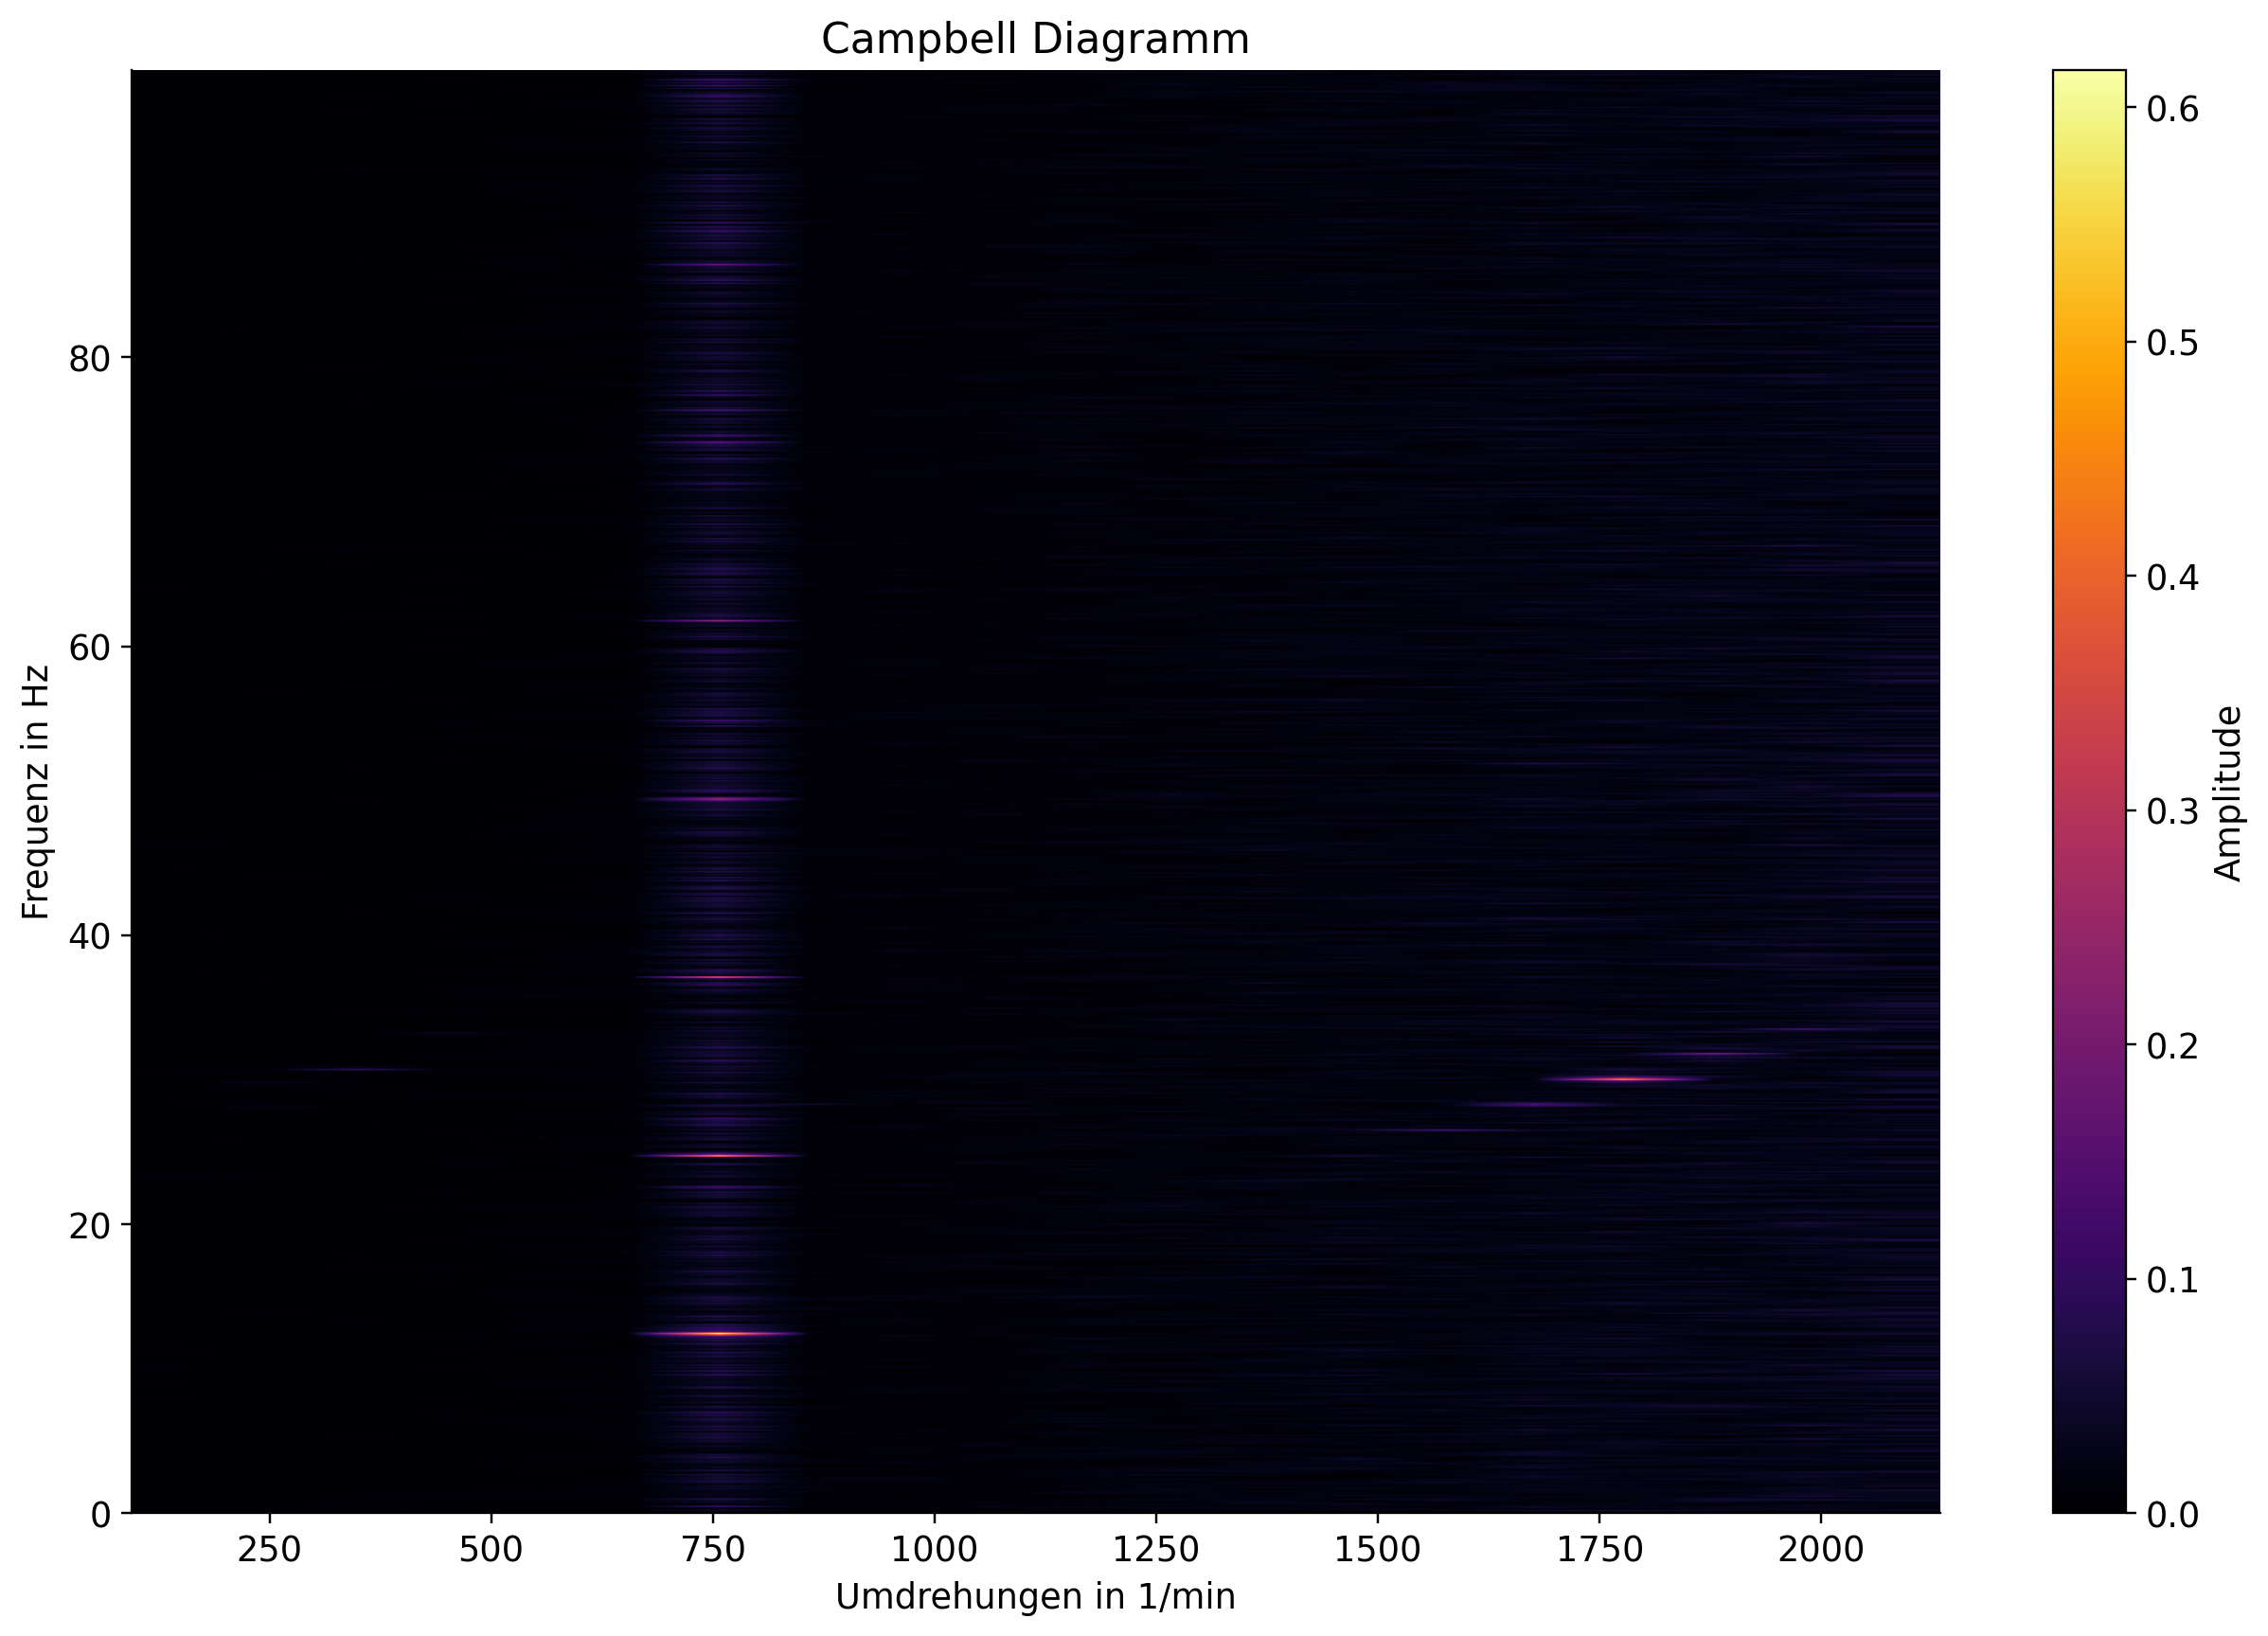

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="inferno",
           origin="lower"  
          )

#Beschriften des Campbell-Diagramms zur besseren Veranschaulichung
plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Zweiter Datensatz: Prüfstand #02

#### 1. Einlesen der Mess- und Metadaten

In [7]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file
h5_path=os.path.join(path_measurement_folder,filename)

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)  


file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

acc_x = []
acc_y = []
acc_z = [] 
time = [] 
rpm = [] 

#Geht alle keys durch
for i in range(len(file.keys())):
    #Checkt, ob der Laufindex i mit einem key übereinstimmt
    for key in file.keys():
        #falls ja, werden Beschleunigungsdaten, Zeitpunkte und Drehzahlen in die Listen appended
        if str(i) == key:
            acc_x.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_x"]))
            acc_y.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_y"]))
            acc_z.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acceleration]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [8]:
importlib.reload(m_postprocessing)  # reload functions

abs_acc = []
interp_data = []
fft_res = []

for i in range(len(acc_x)):
    #Berechnet die absolute Beschleunigung der Daten
    abs_acc.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    
    #Interpoliert die Datenpunkte
    interp_data.append(m_postprocessing.interpolation(time[i], abs_acc[i], interpolation_points))

    #Führt eine Fast-Fourier-Transformation durch
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], interpolation_points))

freq_ex = fft_res[0][1]

amp_res = []

for i in fft_res:
    amp_res.append(i[0])
    
amp_res = np.array(amp_res)

amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

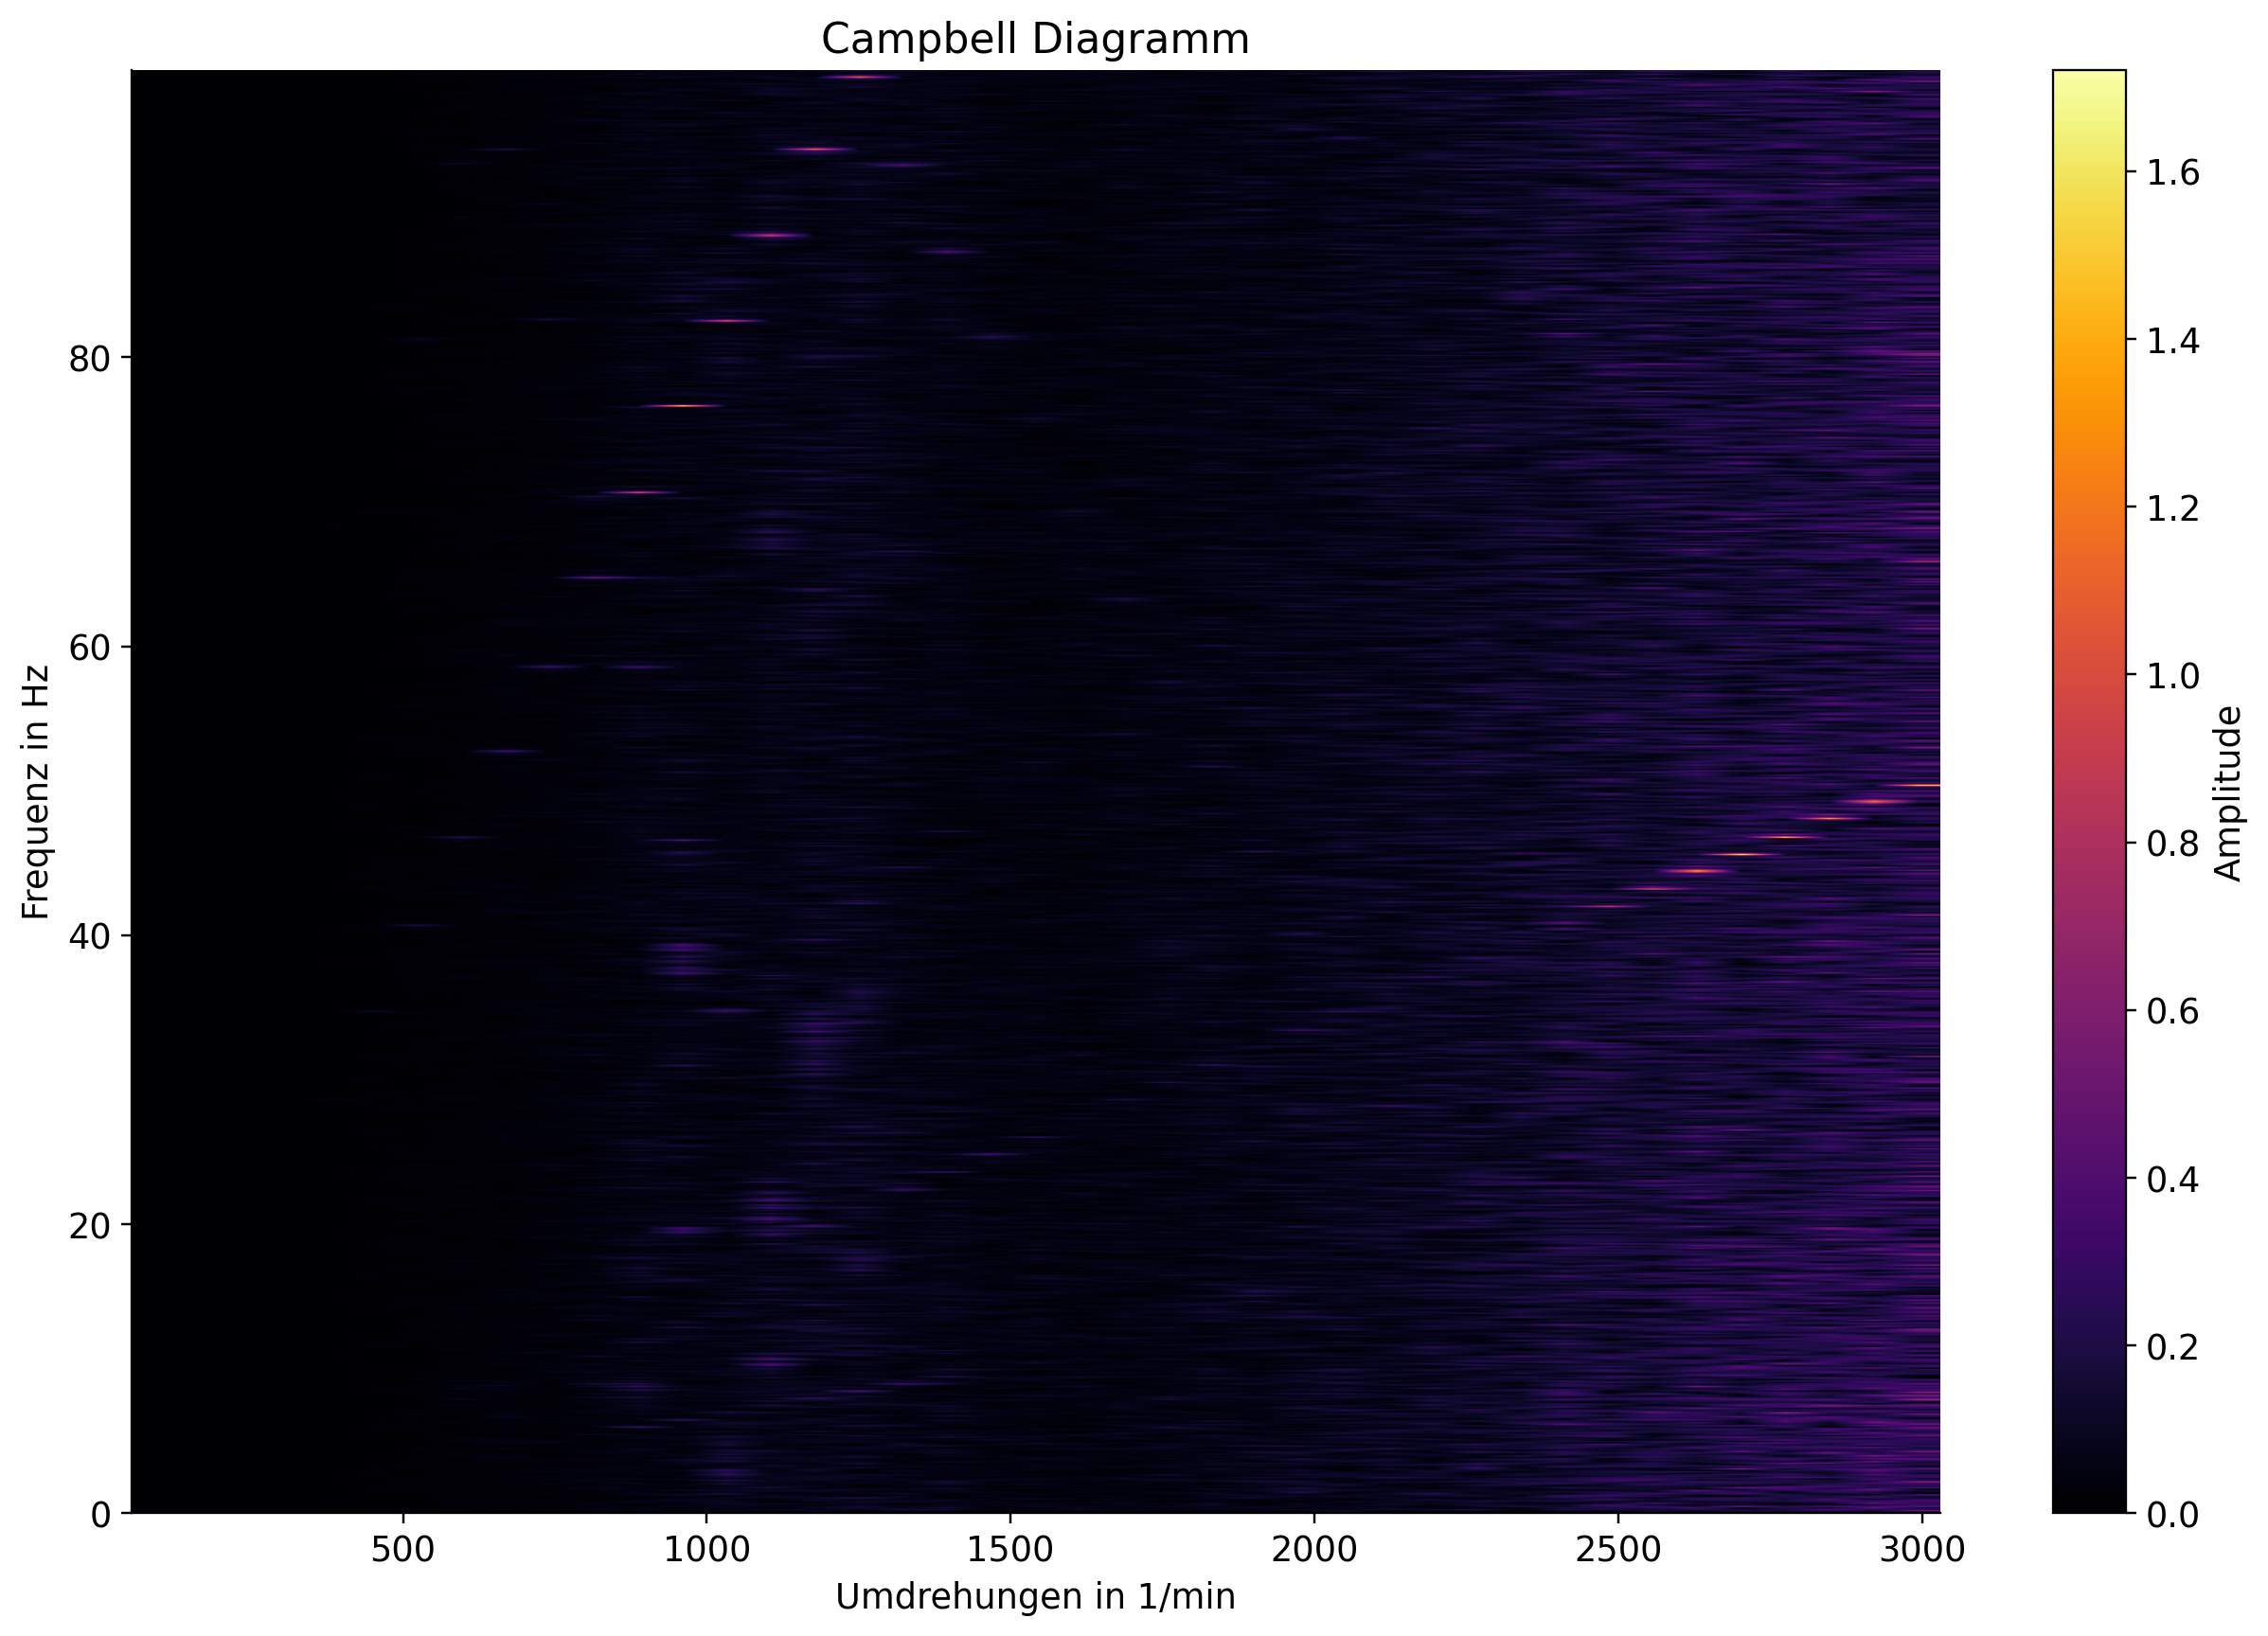

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="inferno",
           origin="lower"  
          )

#Beschriften des Campbell-Diagramms zur besseren Veranschaulichung
plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Dritter Datensatz: Prüfstand #03

#### 1. Einlesen der Mess- und Metadaten

In [10]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file
h5_path=os.path.join(path_measurement_folder,filename)

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)  


file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

acc_x = []
acc_y = []
acc_z = [] 
time = [] 
rpm = [] 

#Geht alle keys durch
for i in range(len(file.keys())):
    #Checkt, ob der Laufindex i mit einem key übereinstimmt
    for key in file.keys():
        #falls ja, werden Beschleunigungsdaten, Zeitpunkte und Drehzahlen in die Listen appended
        if str(i) == key:
            acc_x.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_x"]))
            acc_y.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_y"]))
            acc_z.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acceleration]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [11]:
importlib.reload(m_postprocessing)  # reload functions

abs_acc = []
interp_data = []
fft_res = []

for i in range(len(acc_x)):
    #Berechnet die absolute Beschleunigung der Daten
    abs_acc.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    
    #Interpoliert die Datenpunkte
    interp_data.append(m_postprocessing.interpolation(time[i], abs_acc[i], interpolation_points))

    #Führt eine Fast-Fourier-Transformation durch
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], interpolation_points))

freq_ex = fft_res[0][1]

amp_res = []

for i in fft_res:
    amp_res.append(i[0])
    
amp_res = np.array(amp_res)

amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

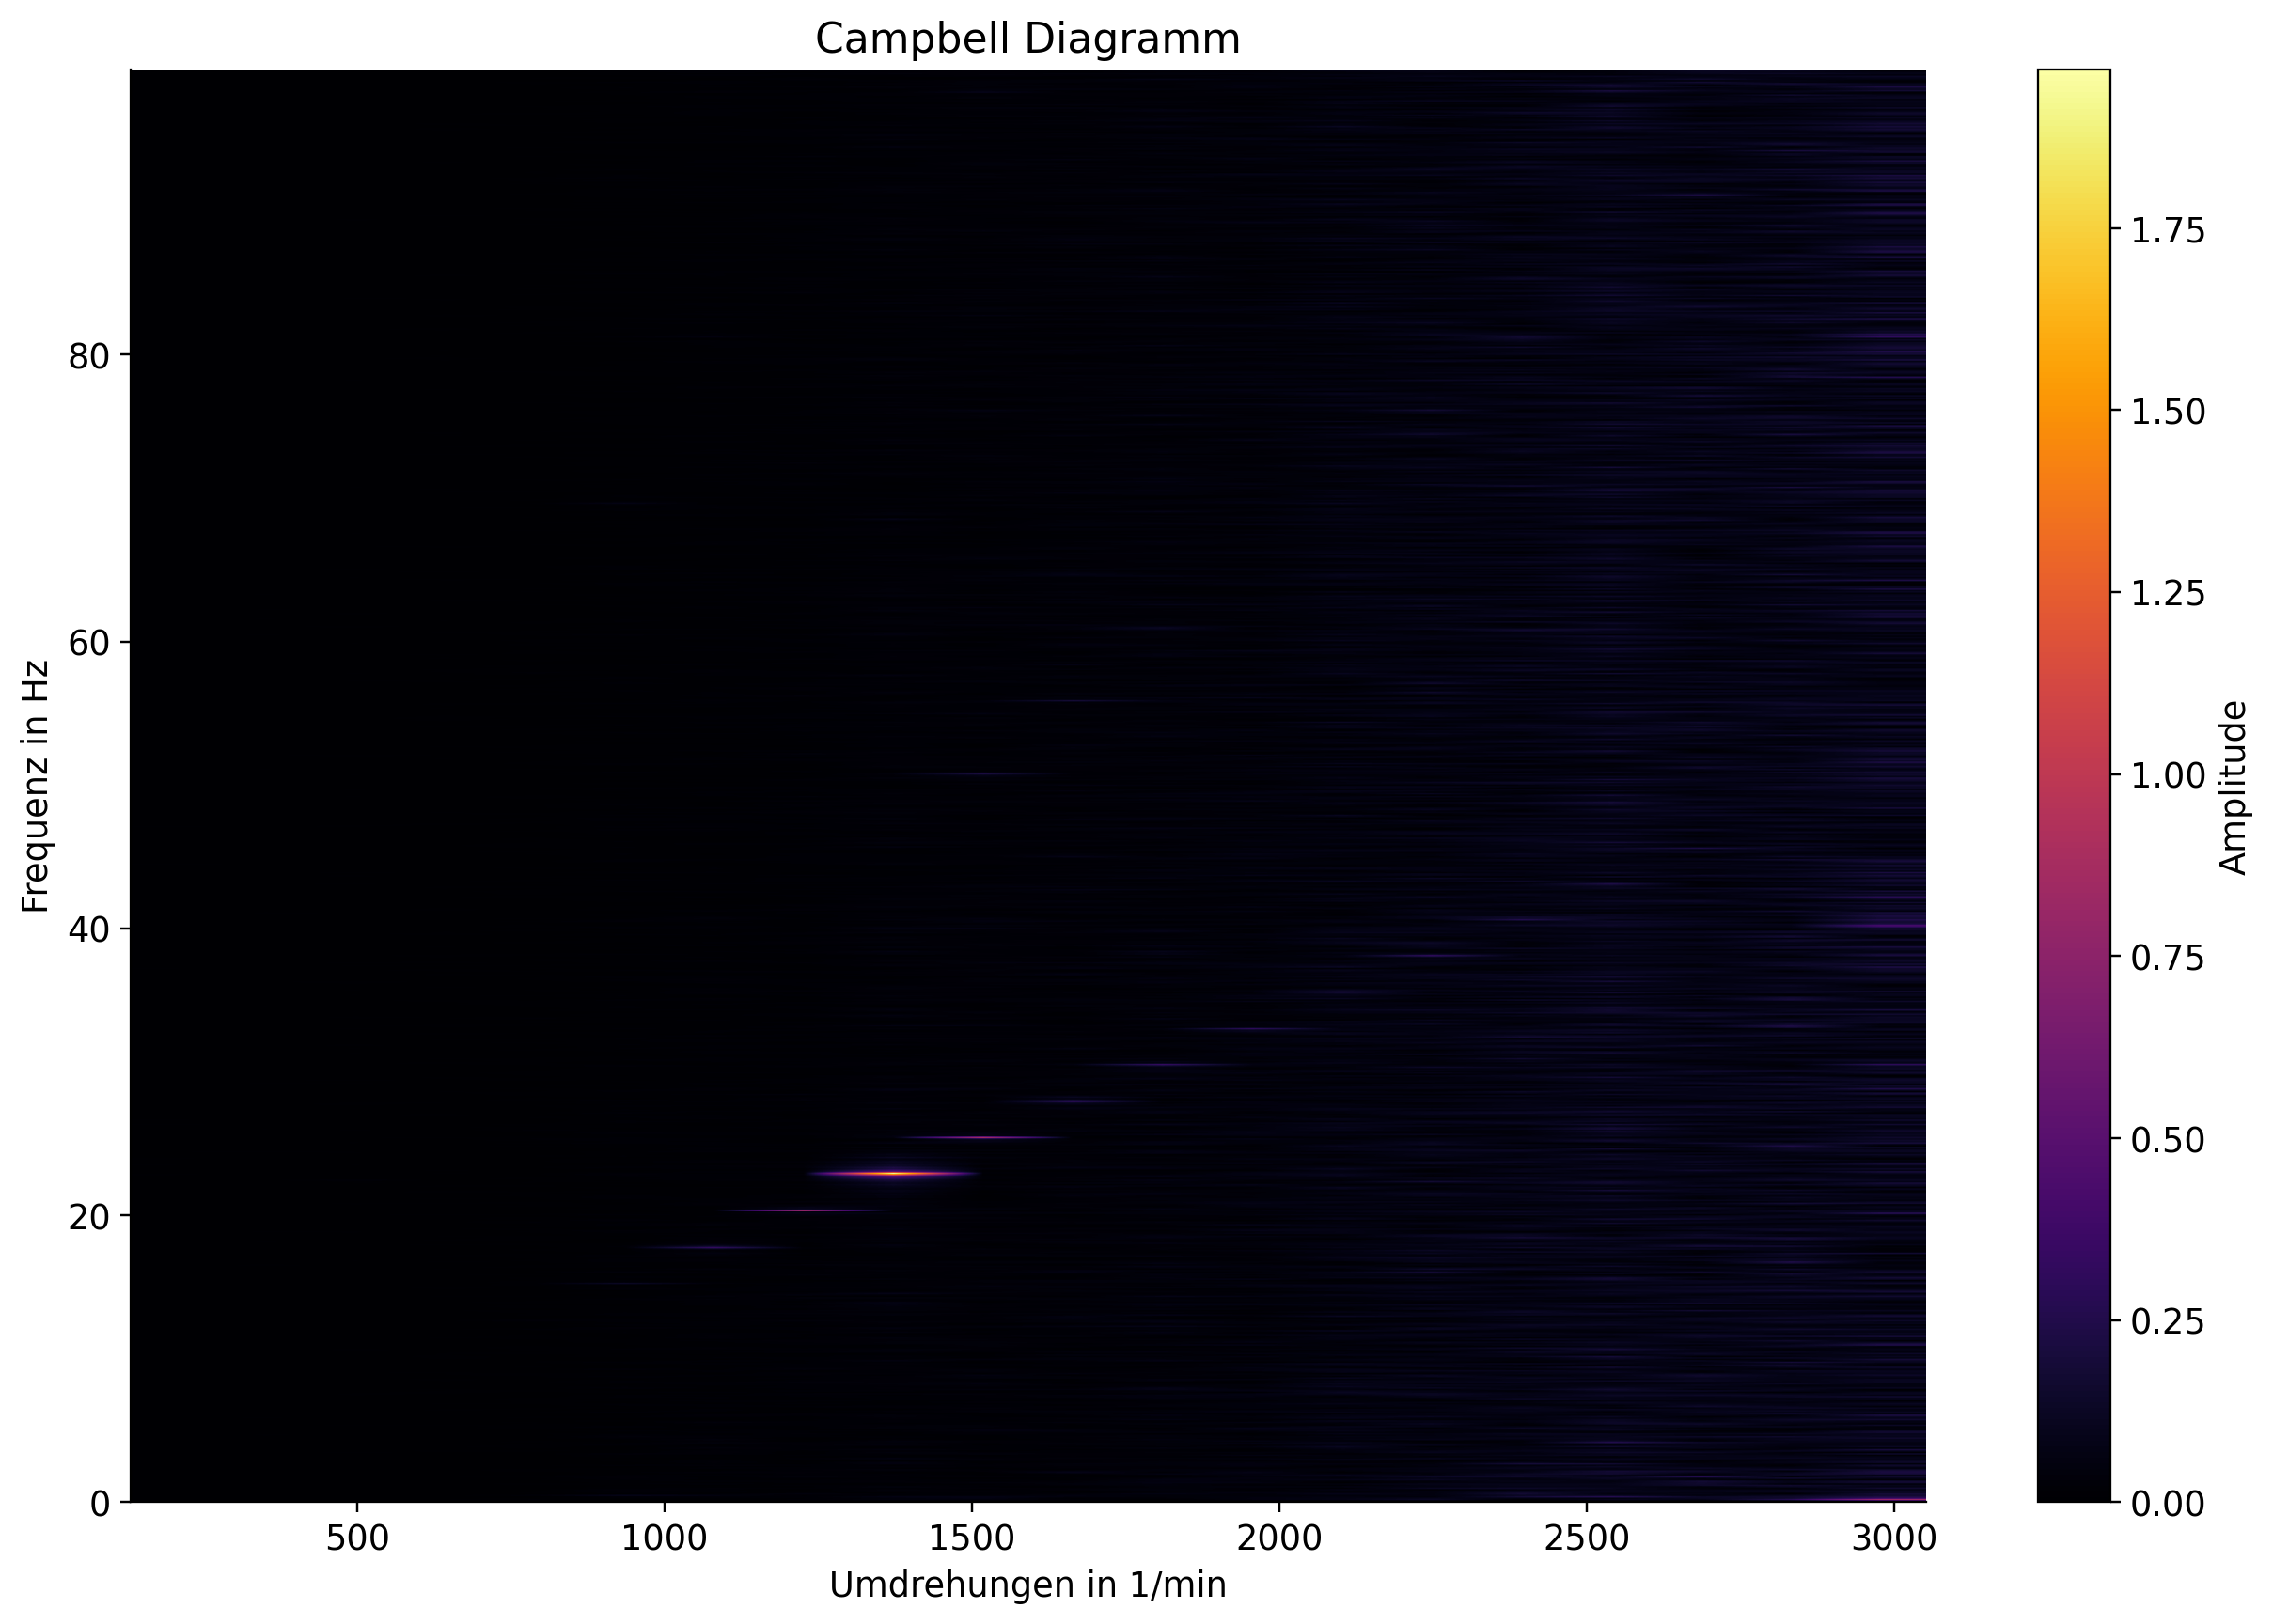

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="inferno",
           origin="lower"  
          )

#Beschriften des Campbell-Diagramms zur besseren Veranschaulichung
plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Datensatz 1: kritische Drehzahl bei ca.

$$
\omega_{krit} = 750 \frac{U}{min}
$$

mit einem relativ großen Nebenmaximum bei 

$$\omega \thickapprox 1750 \frac{U}{min},$$ 

was auf eine relativ schlechte rotordynamische Stabilität hindeutet, da analytisch nur eine kritische Drehzahl existiert.

Datensatz 2: kritische Drehzahlen bei ca. 

$$
\omega_{krit,1} = 1000 \frac{U}{min}, \omega_{krit,2} = 2600 \frac{U}{min},
$$

was auf den ersten Blick plausibel scheint, dass diese größer sind als die aus Datensatz 1, da die beiden Scheiben eine geringere Masse aufweisen und

$$
\omega_{krit} \propto \frac{1}{m^\frac{1}{2}}
$$

Dennoch sind auch hier an dem Campbell-Diagramm einige Nebenmaxima zu erkennen, was ebenfalls auf eine eher instabile Rotordynamik hindeutet.

Datensatz 3: kritische Drehzahl bei knapp

$$
\omega_{krit} = 1500 \frac{U}{min},
$$

wobei einige Nebenmaxima auftauchen, jedoch deutlich begrenzter als in den anderen Datensätzen. Hier ist die rotordynamische Stabilität deutlich besser und die Amplitude lässt sich eindeutig abgrenzen.

Auch wenn insgesamt die Stabilität nicht optimal war, lassen sich in Datensatz 1 und 3 eindeutige Amplituden aus den Diagrammen ablesen. Datensatz 1 und 2 führen, ohne weiteres Hintergrundwissen über den Versuchsaufbau, zu einem verfälschten Ergebnis, da die Diagramme relativ große Nebenmaxima aufweisen, die auf weitere Drehzahlen hindeuten, obwohl nur eine (Datensatz 1) bzw. zwei (Datensatz 2) existieren.

Prinzipiell lassen sich die Selbstzentrierungen durch die abnehmenden Amplituden (erkennbar an der dunkler werdenden Farbe) nach Durchfahren der kritischen Drehzahl(en) der Rotoren erkennen.

Um auf die Forschungsfrage einzugehen: Das Campbell-Diagramm bietet eine sehr schöne Visualisierung der Messdaten zur Bestimmung und Darstellung kritischer Drehzahlen

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
![Berechnung_krit_Drehzahl.jpeg](pictures/Berechnung_krit_Drehzahl.jpeg)


Wie man der Rechnung entnehmen kann, liegt die ablesbare kritische Drehzahl (750 U/min) unseres Prüfstandes im Bereich der errechneten, was auf eine zuverlässige Messung deutet, wenn man das oben genannte Nebenmaximum vernachlässigt. Hierbei gibt es dennoch eine Abweichung von ca. 90 Umdrehungen pro Minute, was schlussendlich auf Vereinfachungen und Annahmen zu führen ist, die in der analytischen Berechnung getroffen wurden (siehe Berechnung der Steifigkeit der Welle).

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Das Experiment war im Großen und Ganzen erfolgreich, da die approximierte kritische Drehzahl aus den händischen Berechnungen in der Nähe der gemessenen und analysierten kritischen Drehzahl von unserem Prüfstand liegt. Hierbei wurden die gegebenen Formeln der Aufgabenstellung verwendet, die nur einen kleinen Einblick in das Thema der Schwingungsanalyse zeigen. Ich konnte dazu mein Verständnis für die Analyse von Daten aus Schwingungsphänomen vertiefen und fand das Experiment äußerst interessant. Ich konnte einen Einblick in das Arbeiten mit einem Campbell-Diagramm erhalten und somit auch erschließen, wie man mögliche Resonanzfälle anschaulich darstellt und erkennt.